# **Генерация описаний к изображениям с использованием CNN и LSTM**

Генерация описаний к изображениям — это задача создания текстового описания для изображения, объединяющая методы компьютерного зрения (CV) и обработки естественного языка (NLP). Она основана на архитектуре "кодировщик-декодировщик", где изображение преобразуется в векторное представление, а затем декодируется в текстовую последовательность.

Для реализации используются сверточные нейронные сети (CNNs) для извлечения признаков изображения и рекуррентные сети (LSTM) для генерации текста. Эмбеддинги изображения объединяются с текстовыми эмбеддингами и передаются в LSTM для последовательного предсказания слов.

## 1. Импорт необходимых библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import nltk
import pandas as pd
import os
import pickle
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Masking
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from nltk import pos_tag
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## 2. Работа с датасетом

In [3]:
# путь к директории, содержащей изображения из датасета Flickr8k
image_path = '/content/drive/MyDrive/dataset/Images'

In [4]:
# загружаем текстовые описания к изображениям
data = pd.read_csv("/content/drive/MyDrive/dataset/captions.txt")
# выводим первые 5 строк
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

### Функции для загрузки и отображения изображений:

In [5]:
# загрузка изображений
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

# отображение изображений на сетке
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

## 2. Визуализация датасета

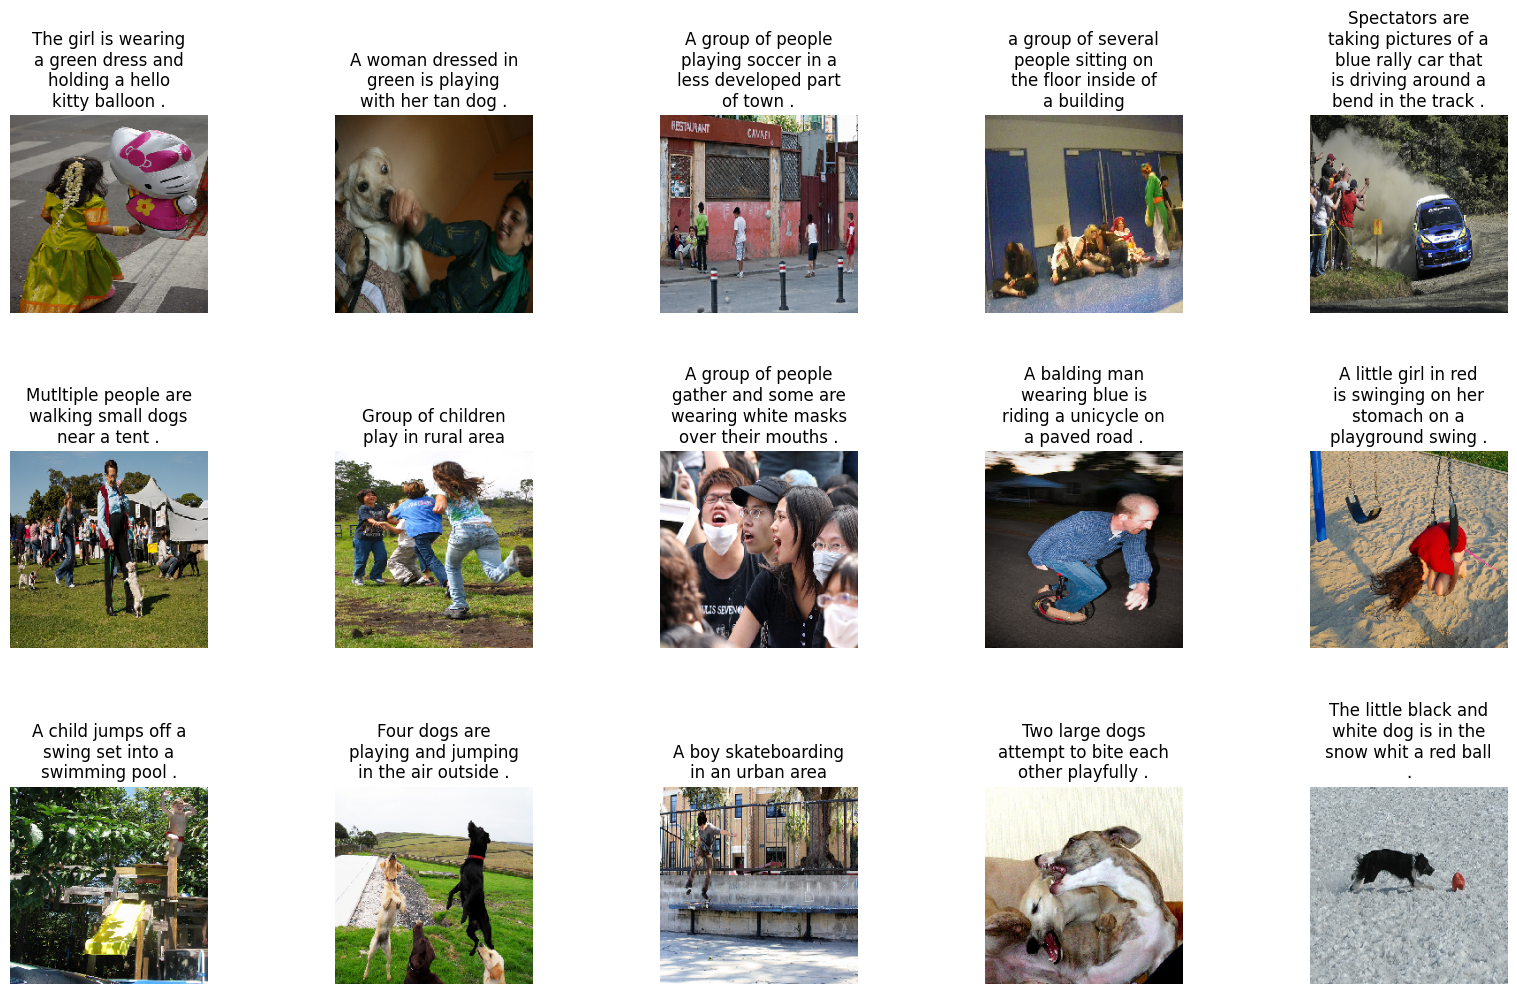

In [6]:
# отображем 15 случайных изображений с описанием
display_images(data.sample(15))

### Распределение комментариев на одно изображение:

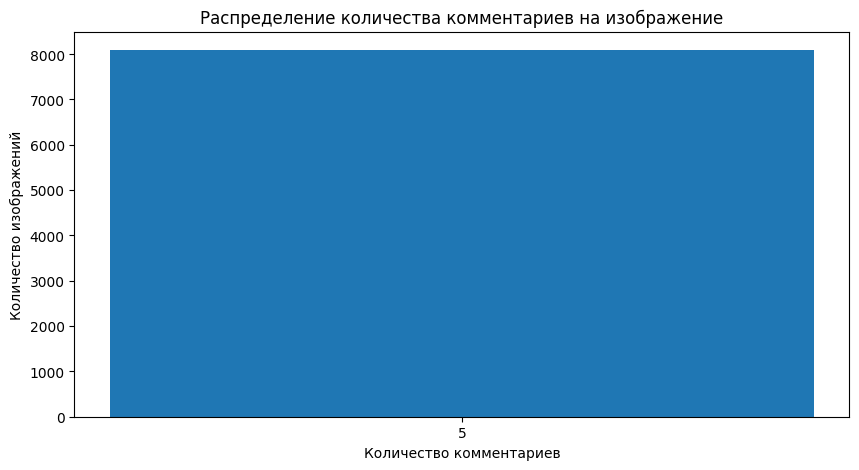

In [7]:
# подсчитываем количество комментариев для каждого изображения
comments_per_image = data.groupby('image')['caption'].count()

# подсчитываем количество изображений для каждого количества комментариев
comment_counts = comments_per_image.value_counts().sort_index()

# построение столбчатой диаграммы
plt.figure(figsize=(10, 5))
plt.bar(comment_counts.index, comment_counts.values)

# оформление осей и заголовка
plt.xlabel('Количество комментариев')
plt.ylabel('Количество изображений')
plt.title('Распределение количества комментариев на изображение')

plt.xticks(comment_counts.index)

# отображаем график
plt.show()

### Облако слов или наиболее встречающиеся слова:

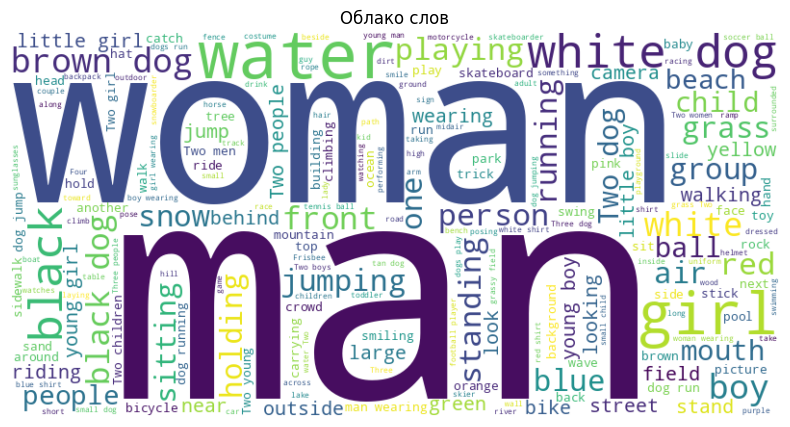

In [8]:
all_comments_text = ' '.join(data['caption'].fillna(''))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов')
plt.show()

### Только существительные:

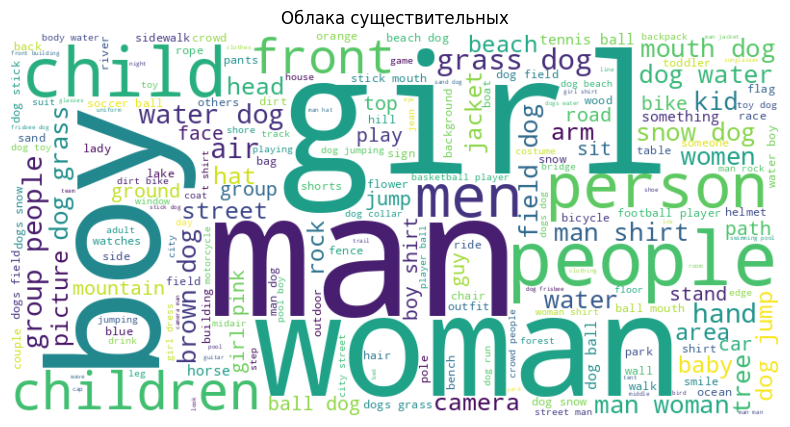

In [9]:
data['pos_tags'] = data['caption'].fillna("").apply(lambda x: pos_tag(word_tokenize(x.lower())))

nouns = [word[0] for tags in data['pos_tags'] for word in tags if word[1].startswith('NN')]

wordcloud_nouns = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nouns))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nouns, interpolation='bilinear')
plt.axis('off')
plt.title('Облака существительных')
plt.show()

### Распределение длины описаний

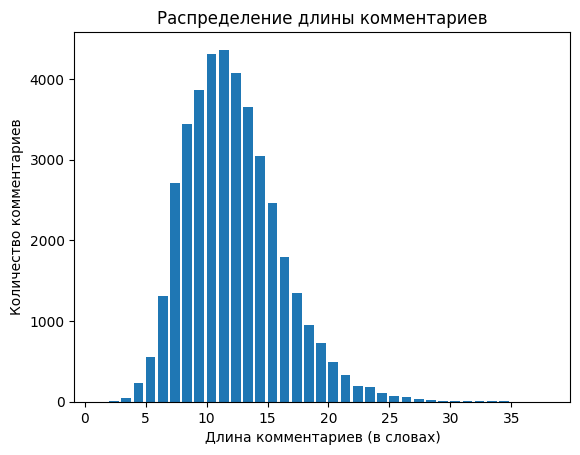

In [10]:
data['caption_length'] = data['caption'].fillna('').apply(lambda x: len(x.split()))
plt.hist(data['caption_length'], bins=range(1, max(data['caption_length']) + 1), width=0.8)
plt.xlabel('Длина комментариев (в словах)')
plt.ylabel('Количество комментариев')
plt.title('Распределение длины комментариев')
plt.show()

## 3. Этапы предобработки текста описаний

*   Преобразование предложений в нижний регистр;
*   Удаление специальных символов и чисел из текста;
*   Удаление лишних пробелов;
*   Удаление одиночных символов;
*   Добавление начального и конечного тега к предложениям для обозначения начала и конца предложения.







In [11]:
def text_preprocessing(data):
    # преобразуем все бувквы в нижний регистр
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    # удаляем все символы, кроме букв латинского алфавита
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    # заменяем несколько пробелов на один
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    # удаляем слова длиной 1 символ
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    # добавляем начальный и конечный тег
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

### Предобработанный текст

In [12]:
data = text_preprocessing(data)
# список строк
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Токенизация и кодирование представления текста

*   Слова в предложении разделяются (токенизируются) и кодируются в формате one-hot представления.
*   Затем эти кодировки передаются в слой эмбеддингов для генерации векторных представлений слов.



In [13]:
tokenizer = Tokenizer()
# обучение токенайзер
tokenizer.fit_on_texts(captions)

# определяем размер словаря и находим максимальную длину описания
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# получаем уникальные имена изображений
images = data['image'].unique().tolist()
# кол-во изображений
nimages = len(images)

# 85% на обучающую выборку, 15 % на валидационную
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# разделяем на обуч. и тестовую выборку
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

# первое описание в числовую последовательность
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [14]:
# сохраняем токенайзер
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Извлечение признаков изображения
Мы используем модель DenseNet201 для извлечения признаков изображений, так как она предобучена на большом наборе данных ImageNet и демонстрирует высокую точность в выделении ключевых визуальных характеристик, что идеально подходит для задачи генерации описаний изображений. Извлеченные признаки будут передаваться в модель LSTM, которая в свою очередь будет генерировать текстовые описания на основе этих признаков.

In [15]:
# загружаем предобученную модель DenseNet201
model = DenseNet201()

# перестроение модели: исключаем последний классификационный слой,
# чтобы использовать предпоследний слой для извлечения признаков
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# определяем размер изображений и создаём словарь для признаков
img_size = 224
features = {}

# ззвлекаем признаки для каждого уникального изображения
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    # преобразуем в массив и нормализуем
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [1:05:24<00:00,  2.06it/s]


In [16]:
# сохраняем признаки в файл
pickle.dump(features, open('features.pkl', 'wb'))

**5. Генерация данных**

Из-за высокой нагрузки на ресурсы при обучении модели генерации описаний изображений мы не можем загрузить все данные в память сразу, поэтому данные генерируются по батчам. Входами для обучения будут эмбеддинги изображений и соответствующие им текстовые эмбеддинги. Во время предсказания текст передается по словам для генерации описания.

Этот класс генерирует данные по батчам, извлекая эмбеддинги изображений и соответствующие им текстовые последовательности. Он используется для обучения модели генерации описаний изображений, эффективно обрабатывая большие объемы данных, не загружая их в память сразу.

In [17]:
class CustomDataGenerator(Sequence):

    # инициализация генератора данных
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        # сохраняем параметры
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    # метод вызывается в конце каждой эпохи, чтобы перемешать данные
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    # возвращаем количество батчей за одну эпоху
    def __len__(self):
        return self.n // self.batch_size

    # метод для получения данных для текущего батча
    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    # метод для получения признаков изображения и последовательностей текста
    def __get_data(self,batch):

         # списки для хранения данных
        X1, X2, y = list(), list(), list()

        # извлекаем изображения из текущего батча
        images = batch[self.X_col].tolist()

        # для каждого изображения извлекаем соответствующий текст
        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                # генерируем входные и выходные последовательности для обучения
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        # преобразуем данные в numpy массивы
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

## 6. Моделирование модели

*   Векторные представления изображения конкатенируются с первым словом предложения, то есть с **starseq**, и передаются в сеть LSTM.
*   Сеть LSTM начинает генерировать слова после каждого ввода, формируя предложение в конце.




/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


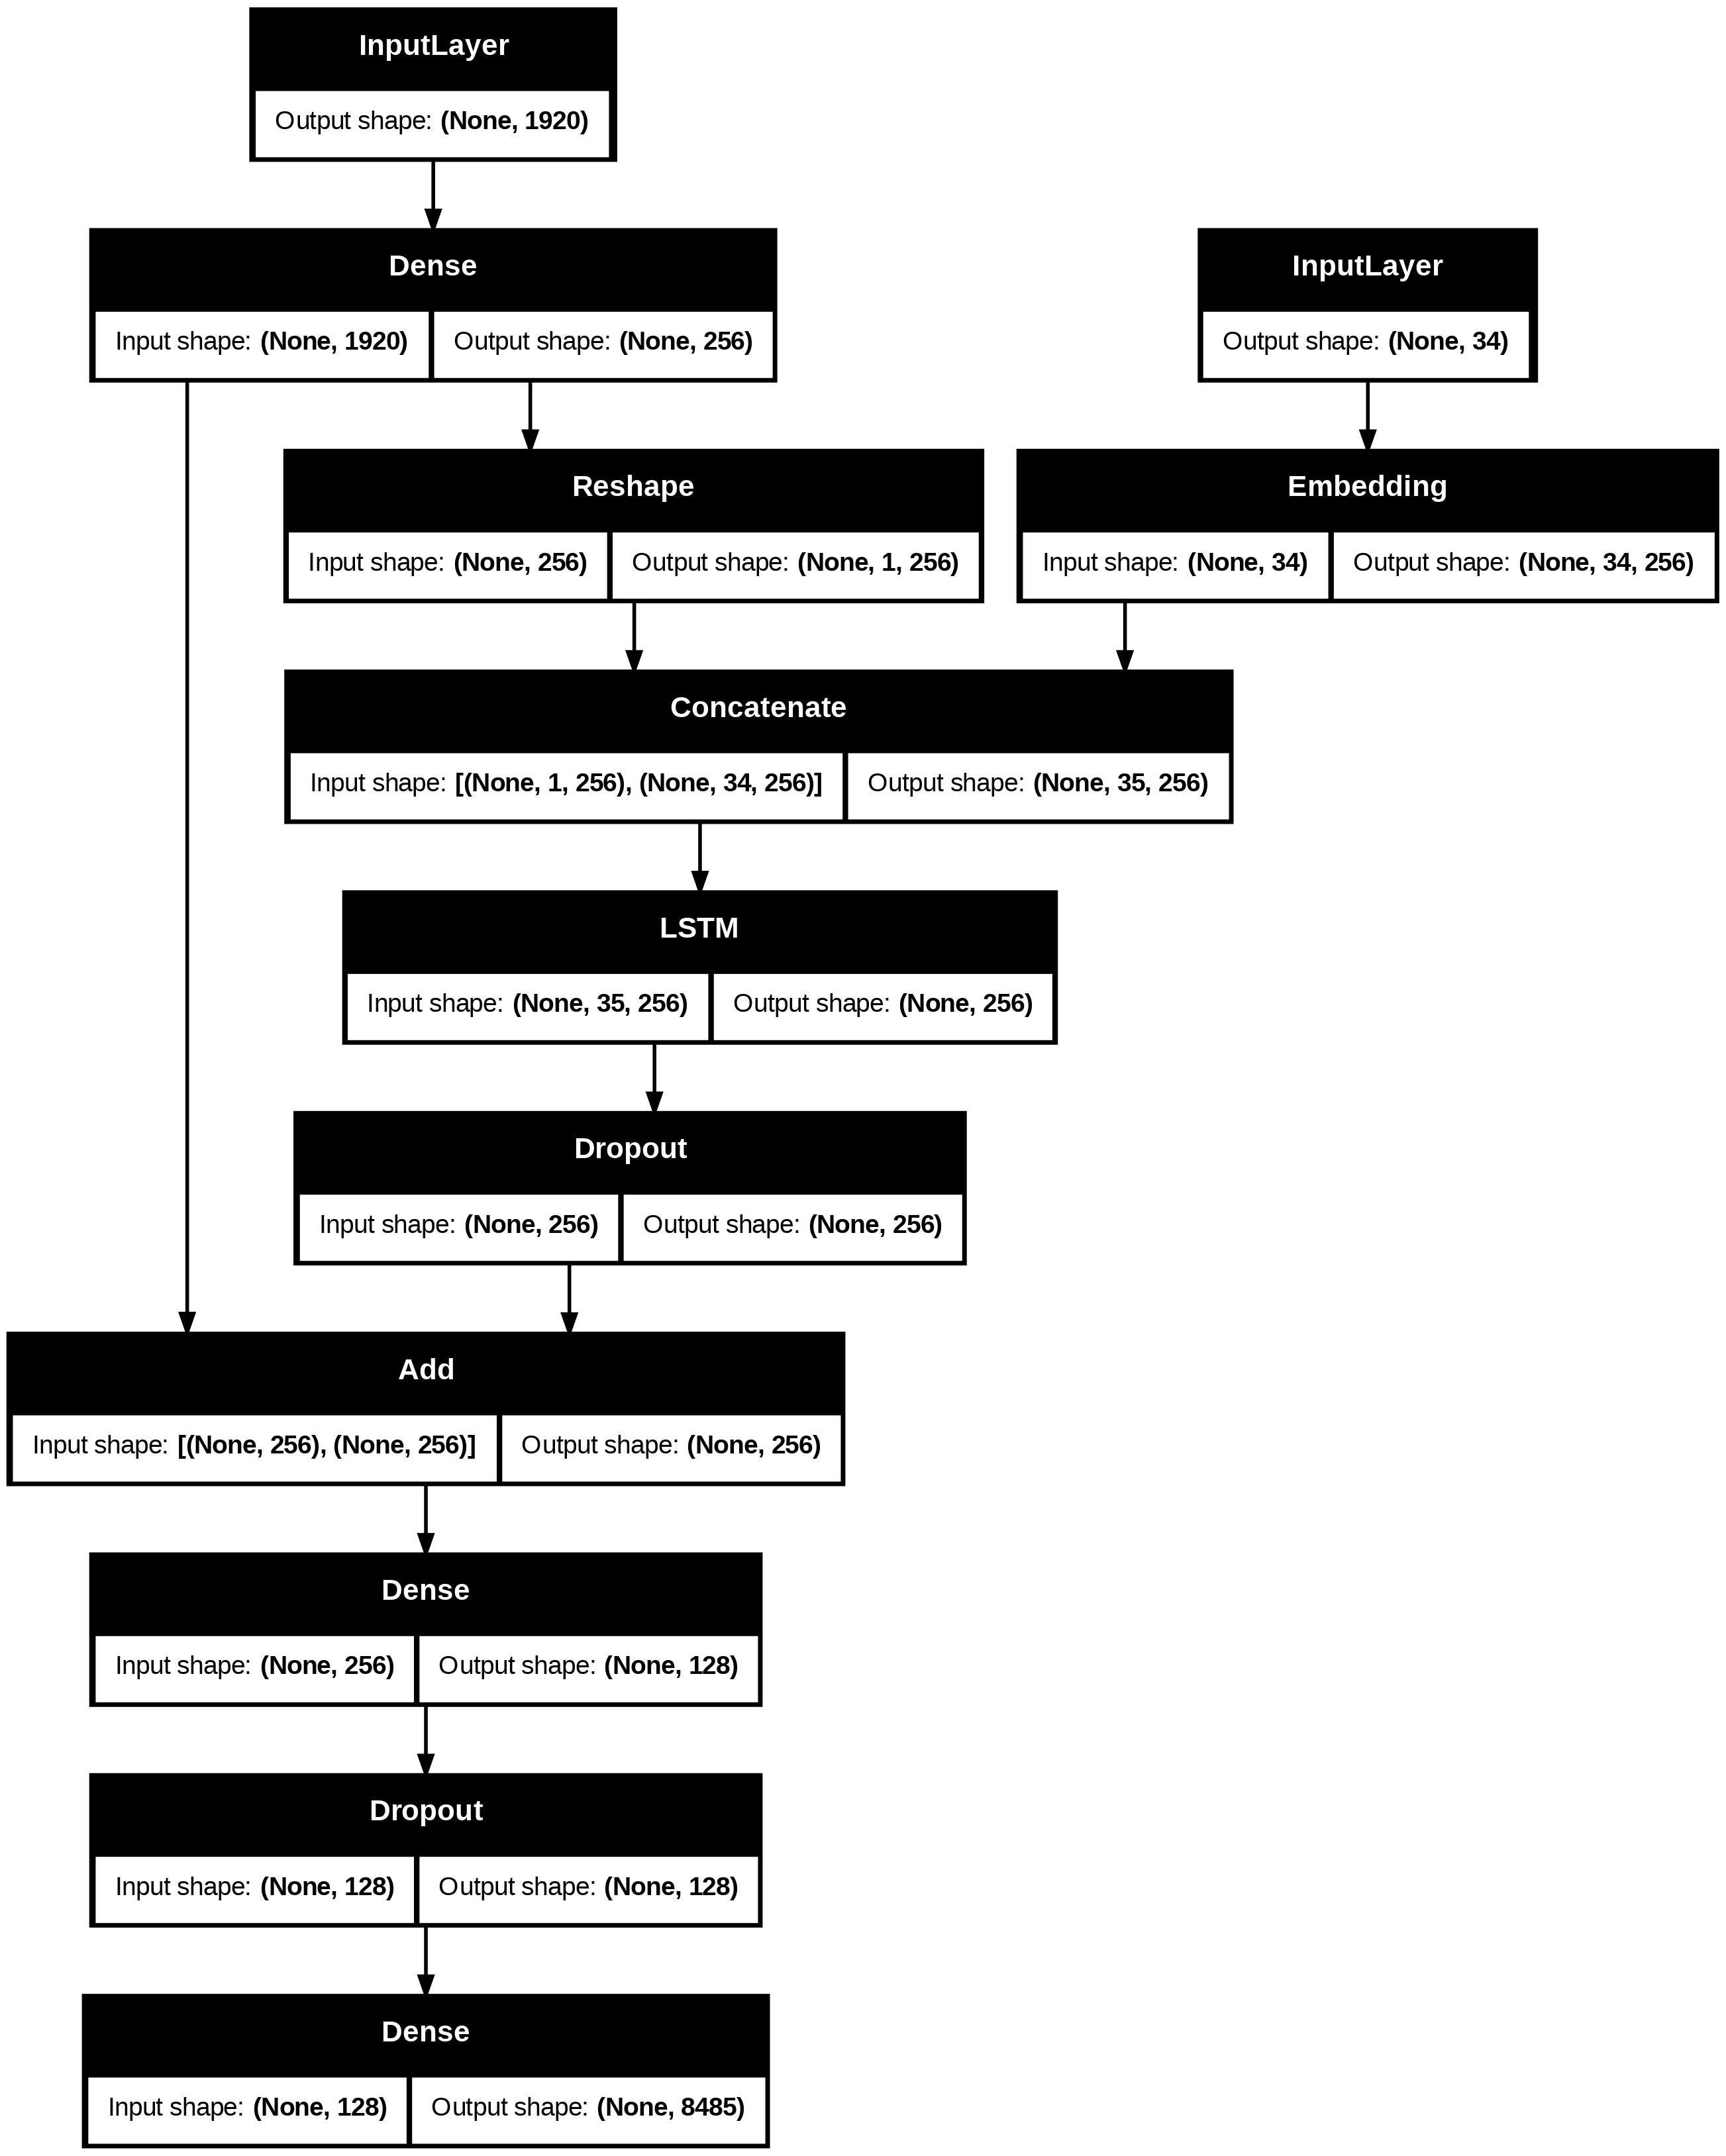

In [18]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

# визуализация модели
plot_model(caption_model, show_shapes=True)

In [19]:
# информация о модели
model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 20,242,984 (77.22 MB)

 Trainable params: 20,013,928 (76.35 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [20]:
# генератор данных для обучения
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# генератор данных для валидации
validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


In [21]:
model_name = "model.keras"

# функция для сохранения модели с наименьшей валидационной потерей
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

# фнкция для остановки обучения при отсутствии улучшений на валидации
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# функция для уменьшения скорости обучения, если валидационная потеря не улучшается
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)


### Обучение модели

In [22]:
# обучение модели с использованием генераторов данных и функций
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 5.6860
Epoch 1: val_loss improved from inf to 4.17624, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 346s 626ms/step - loss: 5.6848 - val_loss: 4.1762 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 4.2138
Epoch 2: val_loss improved from 4.17624 to 3.88905, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - loss: 4.2137 - val_loss: 3.8891 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 3.9193
Epoch 3: val_loss improved from 3.88905 to 3.75437, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 92s 169ms/step - loss: 3.9193 - val_loss: 3.7544 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.7589
Epoch 4: val_loss improved from 3.75437 to 3.68758, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - loss: 3.7588 - val_loss: 3.6876 - learning_rate: 0.0010
Epoch 5/50

### График обучения

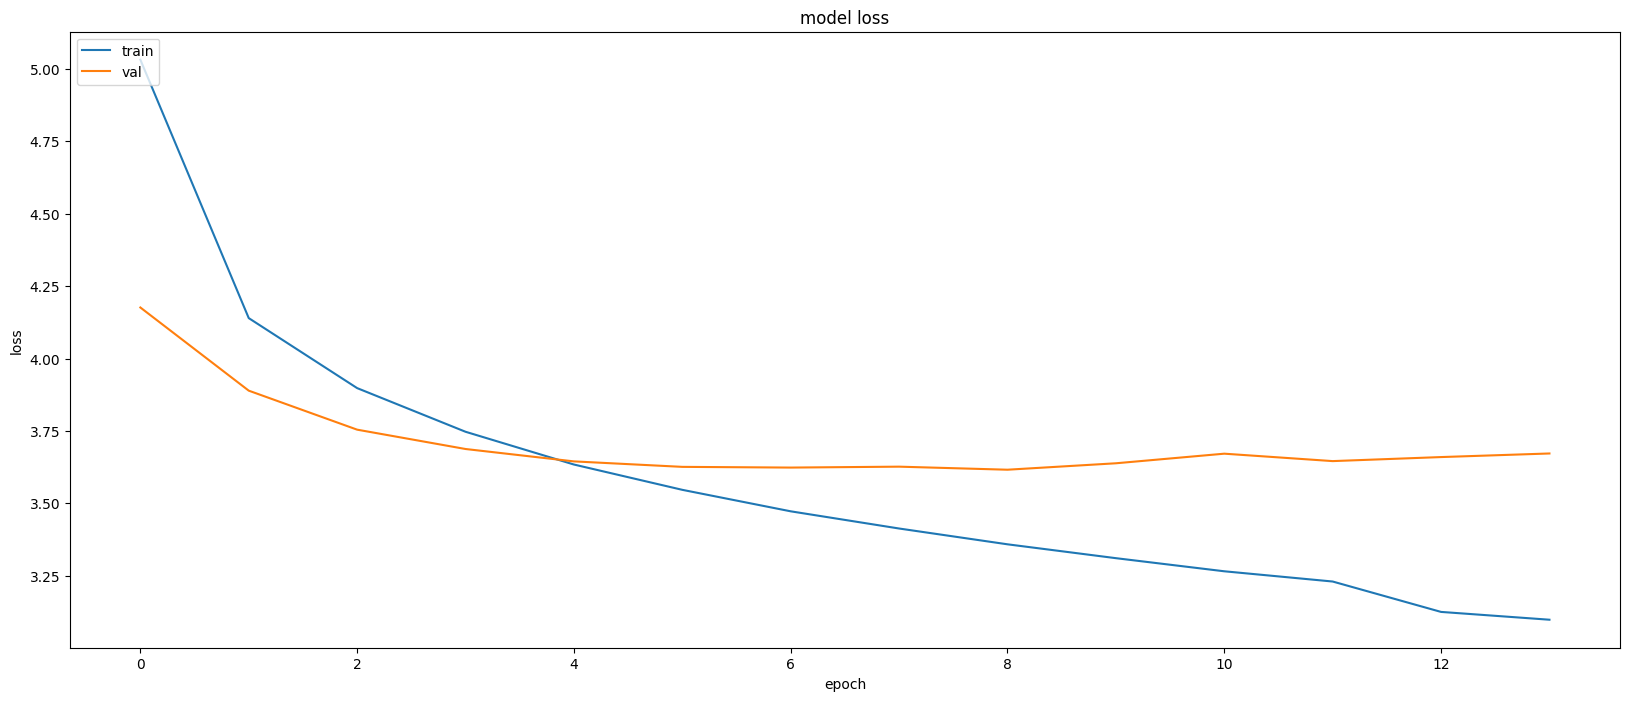

In [23]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 7. Тестирование модели

Функции для тестирования модели, генерирующие подписи к изображениям, используя вектор изображения и текстовые представления слов для последовательной генерации.

In [24]:
 # преобразует индекс в соответствующее слово с использованием словаря токенизатора.
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [25]:
 # генерирует подпись для изображения, используя модель и токенизатор.
 # последовательно предсказывает слова, начиная с "startseq", до достижения "endseq" или максимальной длины.
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

Выбираем 15 случайных изображений из тестового набора для их описания.

In [39]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [40]:
# проходим по строкам samples, загружаем изображения, предсказываем описания и добавляем их в DataFrame
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

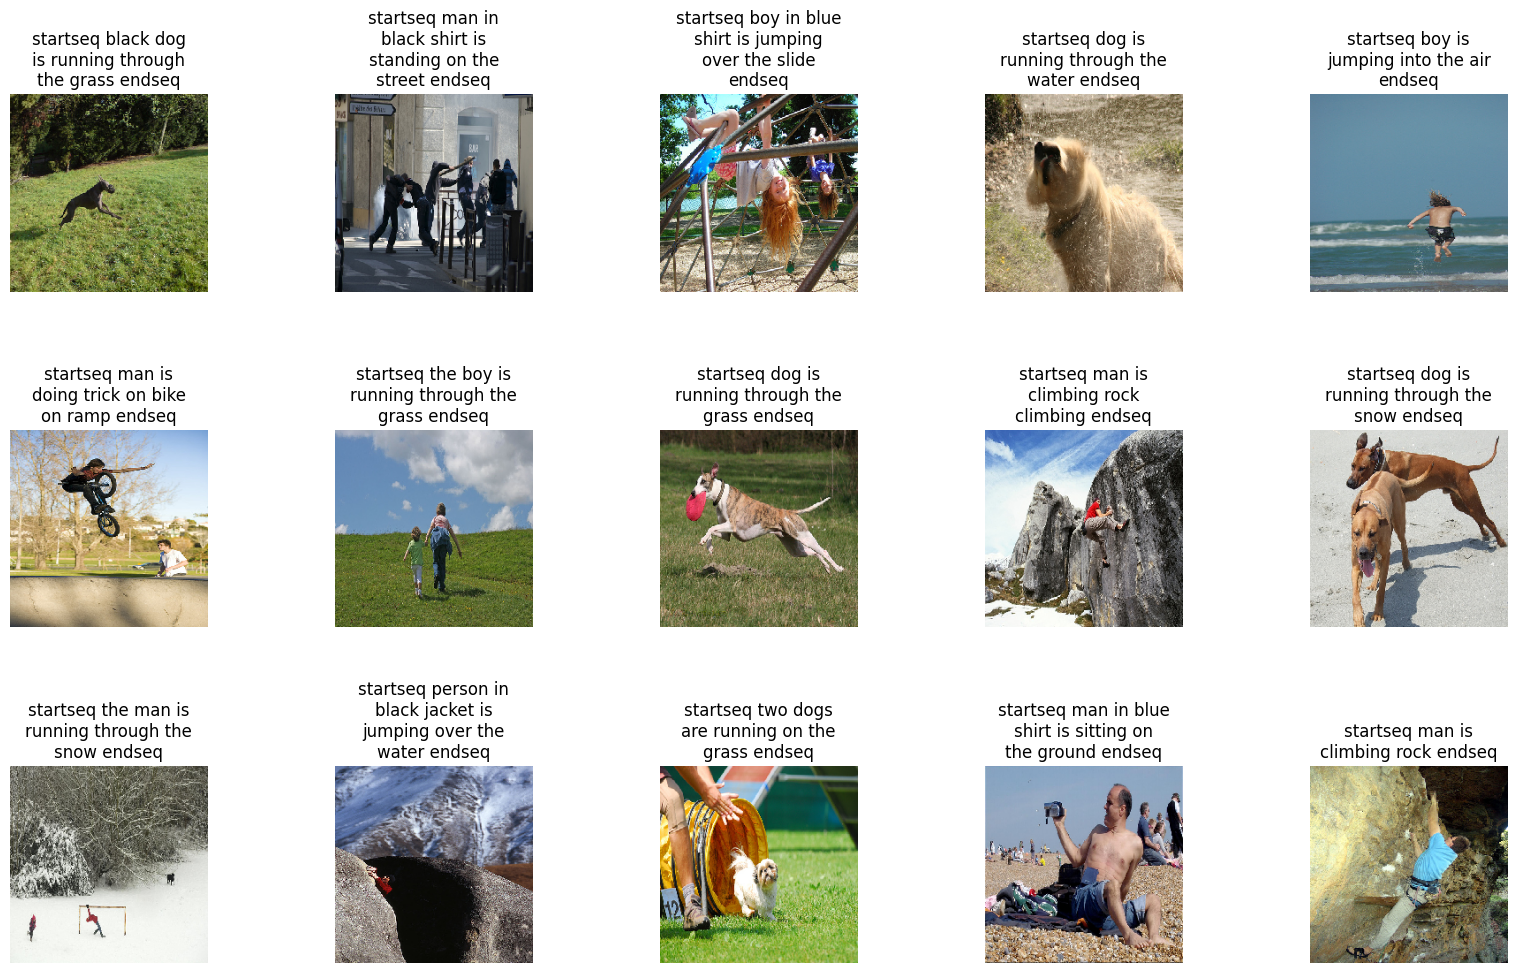

In [41]:
display_images(samples)

In [29]:
def predict_caption_for_image(model, image_file, tokenizer, max_length, features):

    img = load_img(image_file, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.

    img = np.expand_dims(img_array, axis=0) 
    feature = fe.predict(img, verbose=0)

    # генерируем описание
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break

        in_text += " " + word

        if word == "endseq":
            break

    # убираем маркеры 'startseq' и 'endseq'
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Отображаем изображение с подписью
    plt.figure(figsize=(8, 8))
    plt.imshow(img_array) # Отображаем исходное изображение (img_array)
    plt.axis('off')
    plt.title(caption, fontsize=16)
    plt.show()

    return caption

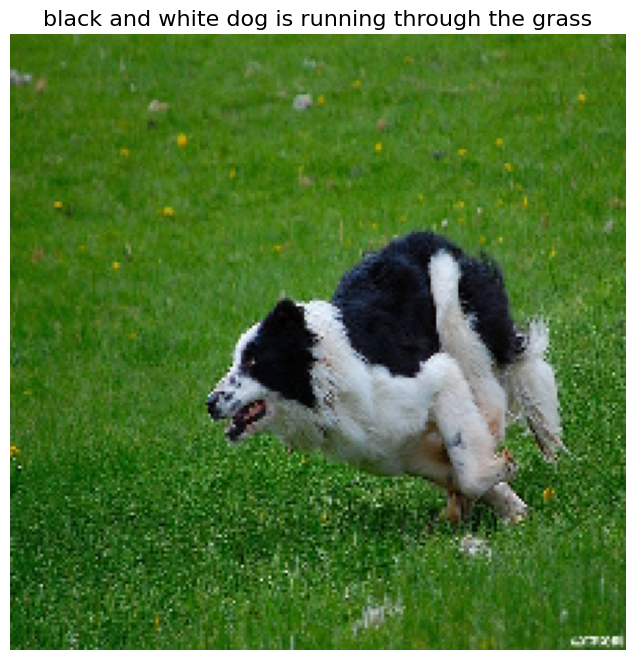

In [32]:
image_file = "/content/drive/MyDrive/images/test1.jpg"
caption = predict_caption_for_image(caption_model, image_file, tokenizer, max_length, features)

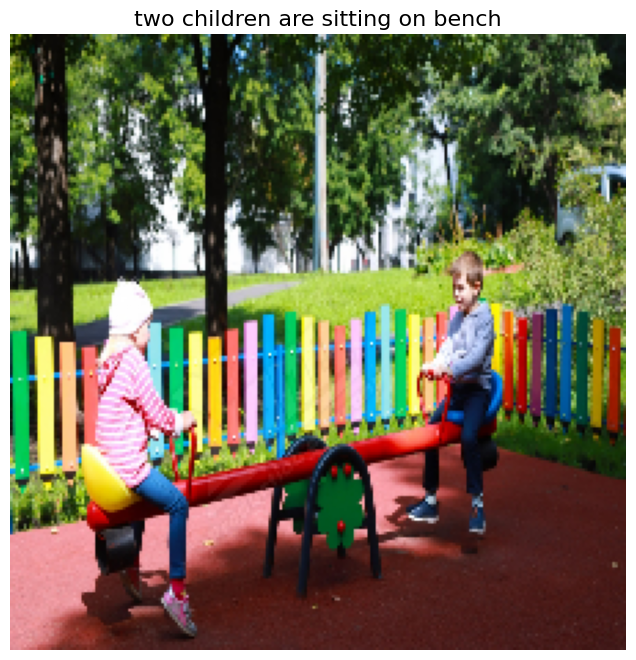

In [33]:
image_file = "/content/drive/MyDrive/images/test2.jpg"
caption = predict_caption_for_image(caption_model, image_file, tokenizer, max_length, features)

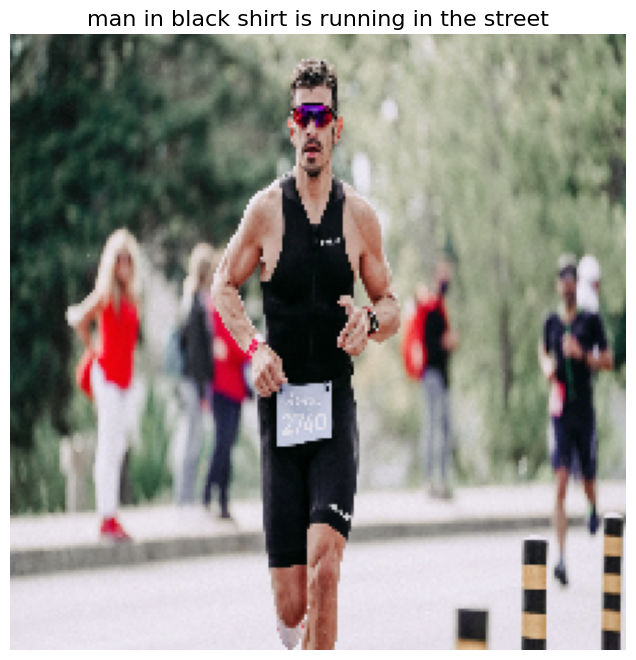

In [34]:
image_file = "/content/drive/MyDrive/images/test3.jpg"
caption = predict_caption_for_image(caption_model, image_file, tokenizer, max_length, features)

BLEU — это метрика для оценки качества текстов, основанная на совпадении n-грамм (последовательностей слов) между предсказанными и эталонными подписями. Чем больше совпадений, тем выше оценка.

In [37]:
import os
import sys
from nltk.translate.bleu_score import corpus_bleu

class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

# проверка с тестовыми данными
actual, predicted = list(), list()

with SuppressOutput():
    for index, record in test.iterrows():
        # извлекаем фактическую подпись
        captions = [record['caption']]  # Извлекаем фактическую подпись из DataFrame 'test'

        # предсказываем подпись для изображения
        y_pred = predict_caption(caption_model, record['image'], tokenizer, max_length, features)

        # разделяем на слова
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()

        # добавляем в список
        actual.append(actual_captions)
        predicted.append(y_pred)

# вычисляем BLEU-1
bleu_score_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))

# вычисляем BLEU-2
bleu_score_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

# вывод результатов
print(f"BLEU-1: {bleu_score_1:.4f}")
print(f"BLEU-2: {bleu_score_2:.4f}")

BLEU-1: 0.3457
BLEU-2: 0.1635
